# Loading Dataset

In [3]:
from datasets import load_dataset

In [4]:
%%capture
dataset = load_dataset("CarterPiepenburg/code-search-net-java-docgen", split="train")

# Preparing Dataset

In [5]:
split_dataset = dataset.train_test_split(test_size=0.3)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Training Model

In [24]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [25]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [26]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj" ,],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",
    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,
    # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [27]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        #warmup_steps = 5,
        warmup_steps = 10,
        #max_steps = 10,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "ft-outputs",
        report_to = [],
    ),
)

In [28]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 700 | Num Epochs = 1 | Total steps = 87
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768/5,000,000,000 (0.37% trained)


Step,Training Loss
1,2.050600
2,2.629400
3,2.296400
4,2.439600
5,1.994500
6,1.627100
7,1.916500
8,1.872600
9,1.911500
10,1.843100


TrainOutput(global_step=87, training_loss=0.9839989323725645, metrics={'train_runtime': 177.4339, 'train_samples_per_second': 3.945, 'train_steps_per_second': 0.49, 'total_flos': 1677707145965568.0, 'train_loss': 0.9839989323725645})

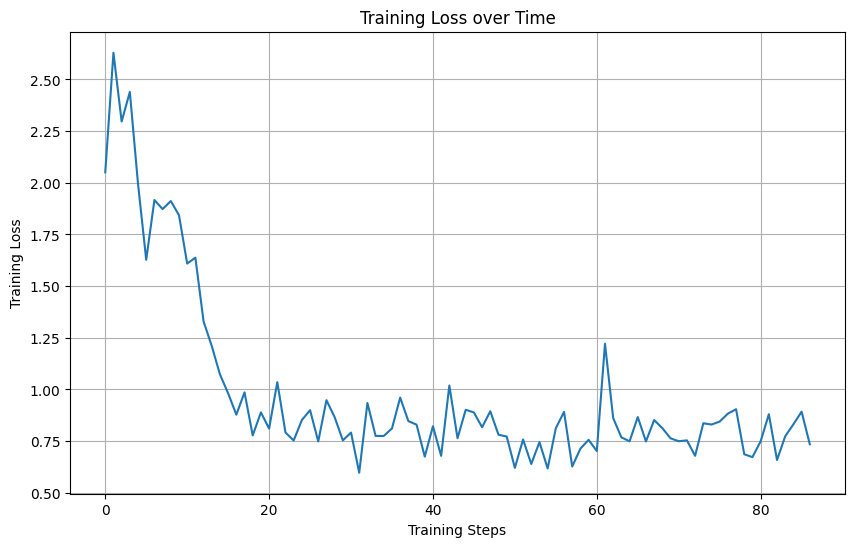

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# After training is complete
training_logs = trainer.state.log_history
# Extract loss values
train_losses = [log.get('loss') for log in training_logs if 'loss' in log]
steps = list(range(len(train_losses)))
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses)
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()

# Evaluation

In [7]:
import numpy as np
import json
import torch
from transformers import TextStreamer
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from safetensors import safe_open
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [8]:
#Loading model and tokenizer from train checkpoint
model = AutoModelForCausalLM.from_pretrained("ft-outputs/checkpoint-87")
tokenizer = AutoTokenizer.from_pretrained("ft-outputs/checkpoint-87")

In [9]:
chat_template = """
{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

# Setup system message consistent with your training
system_message = """You are generating brief documentation for a Java code snippet. "
    "Your response MUST be a single paragraph with NO bullet points, NO line breaks, and NO section headers. "
    "Do NOT explain the prompt. Just output the summary. "
    "Keep your explanation short and focused. Avoid repetition. "
    "Summarize ONLY the core logic and purpose of the code.\n\nSummary (one paragraph only):"""

In [10]:
# Function to run inference on a single example
def generate_explanation(code_to_explain):
    # Prepare user message with Java code for explanation
    user_message = f"Explain what this Java code does: {code_to_explain}"

    # Create the messages list with the system message and user message
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]

    # Apply chat template to format the input consistently with how you trained
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        chat_template = chat_template,
        default_system_message = system_message
    ).to("cuda")

    # Generate response with appropriate parameters for code generation
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            streamer=None,  # No streaming for batch processing
            max_new_tokens=256,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.2,
            top_p=0.9,
            repetition_penalty=1.1
        )

    # Decode the output, skipping the prompt
    generated_text = tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text

In [6]:
# Process examples from rows 700 to 1000
results = []
start_idx = 701
end_idx = 999

# Convert to list if it's a Dataset object to ensure proper indexing
if hasattr(dataset, 'to_list'):
    dataset_list = dataset.to_list()
else:
    dataset_list = dataset

# Make sure we don't exceed the dataset length
end_idx = min(end_idx, len(dataset_list) - 1)
subset = dataset_list[start_idx:end_idx + 1]

print(f"Processing examples from index {start_idx} to {end_idx}")

# Create results directory if it doesn't exist
import os
os.makedirs("evaluation_results", exist_ok=True)

for i, example in enumerate(subset):
    # Extract the code from the user message
    if "conversations" in example:
        user_message = example["conversations"][0]["content"]
        # Extract just the code part (assuming it starts after "Explain what this Python code does: ")
        if "Explain what this Java code does: " in user_message:
            code_part = user_message.split("Explain what this Java code does: ")[1]
        else:
            code_part = user_message  # If no prefix, use the whole message

        # Generate explanation for this code
        explanation = generate_explanation(code_part)

        # Get the reference explanation
        reference_explanation = example["conversations"][1]["content"] if len(example["conversations"]) > 1 else ""

        # Store results
        results.append({
            "index": start_idx + i,
            "code": code_part,
            "reference_explanation": reference_explanation,
            "generated_explanation": explanation
        })

        # Print progress
        print(f"Processed example {start_idx + i} ({i + 1}/{len(subset)})")

        # Print the explanation
        print(f"Original code: {code_part[:100]}...")
        print(f"Generated explanation: {explanation}")
        print("-" * 50)

# Save raw results to a file
with open("evaluation_results/inference_results_1001_1010.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Raw results saved to evaluation_results/inference_results_1001_1010.json")

C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processing examples from index 701 to 999
Processed example 701 (1/299)
Original code: public int[] getTopSentence(int size)
    {
        Collection<Integer> values = top.values();
     ...
Generated explanation: 
--------------------------------------------------
Processed example 702 (2/299)
Original code: static List<String> splitSentence(String document, String sentence_separator)
    {
        List<Str...
Generated explanation: 
--------------------------------------------------
Processed example 703 (3/299)
Original code: private static List<List<String>> convertSentenceListToDocument(List<String> sentenceList)
    {
   ...
Generated explanation: 
--------------------------------------------------
Processed example 704 (4/299)
Original code: public static List<String> getTopSentenceList(String document, int size)
    {
    	return getTopSen...
Generated explanation: 
--------------------------------------------------
Processed example 705 (5/299)
Original code: public static Lis

C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# ============================
# 2. Semantic Similarity Evaluation
# ============================

def evaluate_semantic_similarity(results):
    # Load a sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    similarities = []
    details = []

    for result in results:
        reference = result["reference_explanation"]
        generated = result["generated_explanation"]

        # Skip if either is empty
        if not reference or not generated:
            continue

        # Get embeddings
        ref_embedding = model.encode(reference)
        gen_embedding = model.encode(generated)

        # Calculate cosine similarity
        similarity = float(cosine_similarity([ref_embedding], [gen_embedding])[0][0])
        similarities.append(similarity)

        details.append({
            "index": result["index"],
            "similarity": similarity
        })

        print(f"Example {result['index']} similarity: {similarity:.4f}")

    avg_similarity = float(np.mean(similarities))
    median_similarity = float(np.median(similarities))
    min_similarity = float(np.min(similarities))
    max_similarity = float(np.max(similarities))
    std_similarity = float(np.std(similarities))

    print(f"Average semantic similarity: {avg_similarity:.4f}")
    print(f"Median semantic similarity: {median_similarity:.4f}")
    print(f"Min/Max similarity: {min_similarity:.4f}/{max_similarity:.4f}")
    print(f"Standard deviation: {std_similarity:.4f}")

    return {
        "summary": {
            "mean": avg_similarity,
            "median": median_similarity,
            "min": min_similarity,
            "max": max_similarity,
            "std": std_similarity
        },
        "details": details
    }

In [ ]:
print("\n=== Running Semantic Similarity Evaluation ===\n")
semantic_metrics = evaluate_semantic_similarity(results)